## Agentic RAG

In [1]:
import os 
import warnings
from dotenv import load_dotenv

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
warnings.filterwarnings("ignore")

load_dotenv()

True

In [2]:
from langchain_ollama import ChatOllama

model = "llama3.2:latest"
llm = ChatOllama(model=model, base_url="http://localhost:11434")
print(llm.invoke("Hello, how are you?"))

content="I'm just a computer program, so I don't have feelings or emotions like humans do. However, I'm here to help and assist with any questions or tasks you may have! How can I help you today?" additional_kwargs={} response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-07-15T09:27:48.8594593Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3056054700, 'load_duration': 2056683300, 'prompt_eval_count': 31, 'prompt_eval_duration': 128761900, 'eval_count': 45, 'eval_duration': 868527300, 'model_name': 'llama3.2:latest'} id='run--d453a0d5-b1e1-44a9-bf81-749db2984562-0' usage_metadata={'input_tokens': 31, 'output_tokens': 45, 'total_tokens': 76}


## Retriever

In [3]:
from langchain_ollama import OllamaEmbeddings
import faiss 
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore


In [4]:
embeddings = OllamaEmbeddings(
    model="nomic-embed-text:v1.5",
    base_url="http://localhost:11434"
)

db_name = "gym supplements"
vector_store = FAISS.load_local(db_name, embeddings, allow_dangerous_deserialization=True)

retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 5})

question = "How to gain muscle mass?"
retriever.invoke(question)     

[Document(id='7960e1db-2514-4dd7-b33d-a879fdfe9fb2', metadata={'producer': 'iLovePDF', 'creator': '', 'creationdate': '', 'source': 'rag-dataset\\gym supplements\\2. High Prevalence of Supplement Intake.pdf', 'file_path': 'rag-dataset\\gym supplements\\2. High Prevalence of Supplement Intake.pdf', 'total_pages': 11, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2024-10-21T11:39:04+00:00', 'trapped': '', 'modDate': 'D:20241021113904Z', 'creationDate': '', 'page': 8}, page_content='and strength gain among men. We detected more prevalent protein and creatine supplementation\namong younger compared to older ﬁtness center users, whereas the opposite was found for vitamin\nsupplementation. Other authors made similar observations [23] and it might reﬂect the diﬀerent\ntraining goals among age groups, i.e., more focus on strength and muscles among the younger and\nmore focus on health among the older age groups.\nComparable to other studies [4], we 

In [5]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "gym supplements",
    "Search and return information about the gym supplements for workout and gym."
)

tools = [retriever_tool]

In [6]:
tools 

[Tool(name='gym supplements', description='Search and return information about the gym supplements for workout and gym.', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x000002B74DAD8E00>, retriever=VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002B761FA9160>, search_kwargs={'k': 5}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x000002B74DADA200>, retriever=VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002B761FA9160>, search_kwargs={'k': 5}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_vari

## Agentic RAG Graph

In [7]:
from typing import Annotated, Sequence, TypedDict, Literal
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [8]:
from langchain import hub 
from langchain_core.messages import HumanMessage, BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition

## Document Grader

In [9]:
def grade_documents(state) -> Literal ["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state 
        
    Returns: 
        str: A decision for whether the documents are relevant or not.
    """
    
    print("---CHECK RELEVANCE---")
    
    #Data Model
    class grade(BaseModel):
        """Binary score for relevance check."""
        
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")
        
    #LLM with tool and validation
    llm_with_structured_output = llm.with_structured_output(grade)
    
    #Prompt 
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score of 'yes' or 'no' to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )
    
    #Chain
    chain = prompt | llm_with_structured_output 
    
    messages = state["messages"]
    last_message = messages[-1]
    
    question = messages[0].content
    docs = last_message.content
    
    scored_result = chain.invoke({"question": question, "context": docs})
    
    score = scored_result.binary_score 
    
    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"
    
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

### Agent Node

In [10]:
tools 

[Tool(name='gym supplements', description='Search and return information about the gym supplements for workout and gym.', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x000002B74DAD8E00>, retriever=VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002B761FA9160>, search_kwargs={'k': 5}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x000002B74DADA200>, retriever=VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002B761FA9160>, search_kwargs={'k': 5}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_vari

In [11]:
def agent(state):
    """
    Invokes the agent to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriver tool, or simply end.
    
    Args:
        state (messages): The current state
        
    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    
    llm_with_tools = llm.bind_tools(tools, tool_choice="required")
    response = llm_with_tools.invoke(messages)
    #We return a list, because this will get added to the existing list 
    return {"messages": [response]}


### Rewrite Node

In [12]:
def rewrite(state):
    """
    Transform the query to produce a better question.
    
    Args:
        state (messages): The current state
        
    Returns:
        dict: The updated state with re-phrased question 
    """
    
    print("--TRANSFORM QUERY--")
    messages = state["messages"]
    question = messages[0].content
    
    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question: 
    \n -------- \n 
    {question}
    \n -------- \n
    Formulate an improved question: """,
        )
    ]
    
    #Grader 
    response = llm.invoke(msg)
    return {"messages": [response]}

### Generate Node

In [13]:
def generate(state): 
    """ 
    Generate answer
    
    Args:
        state (messages): The current state
        
    Returns:
        dict: The updated state with re-phrased question
    """
    print("--GENERATE--")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    
    docs = last_message.content
    
    #Prompt
    prompt = hub.pull("rlm/rag-prompt")
    
    #Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    #Chain
    rag_chain = prompt | llm | StrOutputParser()
    
    #Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

## Graph

In [14]:
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode


In [15]:
graph_builder = StateGraph(State)

graph_builder.add_node("agent", agent)
retriever = ToolNode([retriever_tool])
graph_builder.add_node("retriever", retriever)
graph_builder.add_node("rewrite", rewrite)

graph_builder.add_node("generate", generate)


graph_builder.add_edge(START, "agent")


graph_builder.add_conditional_edges(
    "agent",
    
    
    tools_condition,
    {
        "tools": "retriever",
        END: END
    }
)

graph_builder.add_conditional_edges(
    "retriever",
    grade_documents
)

graph_builder.add_edge("generate", END)
graph_builder.add_edge("rewrite", "agent")

graph = graph_builder.compile()


In [16]:
retriever

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'gym supplements': Tool(name='gym supplements', description='Search and return information about the gym supplements for workout and gym.', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x000002B74DAD8E00>, retriever=VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002B761FA9160>, search_kwargs={'k': 5}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x000002B74DADA200>, retriever=VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.f

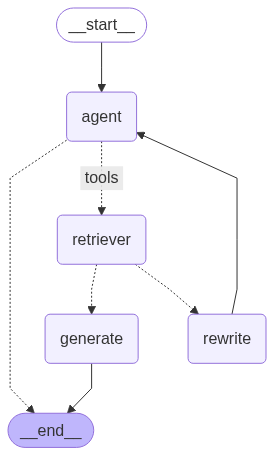

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
from pprint import pprint 

# query = {"messages": [HumanMessage("How to gain muscle mass?")]}
query = {"messages": [HumanMessage("Tell me about langchain?")]}

#graph.invoke(query)

for output in graph.stream(query):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("-----")
        pprint(value, indent=4, width=120)
        
        
    pprint("\n-------\n")

---CALL AGENT---
"Output from node 'agent':"
'-----'
{   'messages': [   AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-07-15T09:27:53.9047867Z', 'done': True, 'done_reason': 'stop', 'total_duration': 603166200, 'load_duration': 51148900, 'prompt_eval_count': 172, 'prompt_eval_duration': 16975400, 'eval_count': 19, 'eval_duration': 534098300, 'model_name': 'llama3.2:latest'}, id='run--c22494d7-963f-42a0-94fb-d94898221fba-0', tool_calls=[{'name': 'gym supplements', 'args': {'query': 'langchain'}, 'id': 'bcffc36a-e556-4db9-8279-a1f103f6aab3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 172, 'output_tokens': 19, 'total_tokens': 191})]}
'\n-------\n'
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output from node 'retriever':"
'-----'
{   'messages': [   ToolMessage(content='metabolizing enzymes. As such, induction or suppression of relevant metabolizing enzymes \ncan affect the pharmacokinetics of drug